# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
#install

!pip install fastprogress

In [3]:
from collections import deque
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from ddpg import Agent
from tqdm import tqdm
from unityagents import UnityEnvironment
import numpy as np
from fastprogress import progress_bar, master_bar

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [4]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### Init agents for execution

In [8]:
agent_player_1 = Agent(state_size, action_size)
agent_player_2 = Agent(state_size, action_size)

In [9]:
def ddpg_tennis(n_episodes=8000, max_t=1000, train_mode=True):
    scores_deque = deque(maxlen=100)
    scores_all = []    
    mean_avg_scores = []
    achieved = False
    
    mb = master_bar(range(1, n_episodes+1))
    for i_episode in mb:
        env_info = env.reset(train_mode)[brain_name]
        states = env_info.vector_observations
        agent_player_1.reset()
        agent_player_2.reset()
        scores = np.zeros(num_agents)
        for t in progress_bar(range(max_t), parent=mb):
            action0 = agent_player_1.act(states[0], add_noise=True)    
            action1 = agent_player_1.act(states[1], add_noise=True)    
            env_info = env.step([action0, action1])[brain_name]
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            agent_player_1.step(states[0], action0, rewards[0], next_states[0], dones[0])
            agent_player_2.step(states[1], action1, rewards[1], next_states[1], dones[1])
            states = next_states
            scores += rewards
            if np.any(dones):
                break
           
        scores_deque.append(np.max(scores))
        scores_all.append(np.max(scores))
        mean_avg_scores.append(np.mean(scores_deque))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tScore {:.2f}\tAverage Score {:.2f}'.format(i_episode, np.max(scores_all), np.mean(scores_deque)))
        
        if np.mean(scores_deque) >= 0.5 and achieved is False:
            print('Score of', np.mean(scores_deque), 'achieved in', i_episode, 'episodes')
            torch.save(agent_player_1.actor_local.state_dict(), 'checkpoint_actor0.pth')
            torch.save(agent_player_1.critic_local.state_dict(), 'checkpoint_critic0.pth')
            torch.save(agent_player_2.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent_player_2.critic_local.state_dict(), 'checkpoint_critic1.pth')
            achieved = True
            
        if(np.mean(scores_deque) >= 0.6):
            torch.save(agent_player_1.actor_local.state_dict(), 'checkpoint_actor0.pth')
            torch.save(agent_player_1.critic_local.state_dict(), 'checkpoint_critic0.pth')
            torch.save(agent_player_2.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent_player_2.critic_local.state_dict(), 'checkpoint_critic1.pth')
            break
        
    return scores_all, mean_avg_scores

In [10]:
scores, avg_scores = ddpg_tennis()

Episode 100	Score 0.10	Average Score 0.00
Episode 200	Score 0.10	Average Score 0.00
Episode 300	Score 0.10	Average Score 0.00
Episode 400	Score 0.20	Average Score 0.01
Episode 500	Score 0.20	Average Score 0.00
Episode 600	Score 0.20	Average Score 0.00
Episode 700	Score 0.20	Average Score 0.03
Episode 800	Score 0.20	Average Score 0.04
Episode 900	Score 0.20	Average Score 0.04
Episode 1000	Score 0.60	Average Score 0.06
Episode 1100	Score 0.60	Average Score 0.11
Episode 1200	Score 0.60	Average Score 0.11
Episode 1300	Score 0.70	Average Score 0.15
Episode 1400	Score 0.70	Average Score 0.14
Score of 0.509400007613 achieved in 1477 episodes


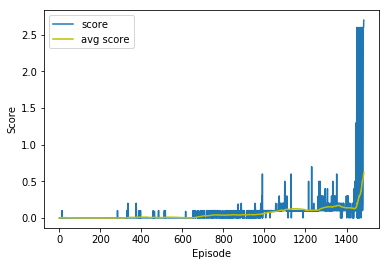

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='score')
plt.plot(np.arange(1, len(scores)+1), avg_scores, c='y', label='avg score')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend(loc='upper left')
plt.show()

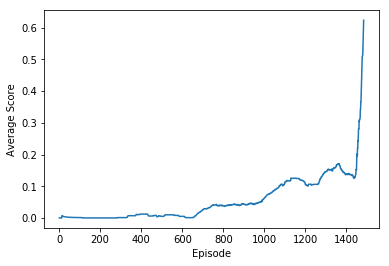

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores)
plt.ylabel('Average Score')
plt.xlabel('Episode')
plt.show()

In [19]:
env.close()

When finished, you can close the environment.